In [7]:
import networkx as nx
import numpy as np
import sys, os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

# Class definition

In [58]:
def get_first_inverse(pi):
  '''
  @param: d is a vector / list of degree densities, where index are degree, values are p_i
  @returns: the first inverse moment of the degree distribution
  '''
  res = 0.0
  for d in range(len(pi)):
    if pi[d] == 0:
      continue
    res += pi[d] * (1/d)
  return res

class Graph:
  def __init__(self, filename):
    self.G = nx.read_edgelist(filename,nodetype=int)
    self.list = [list(nbrdict.keys()) for _, nbrdict in self.G.adjacency()]
    arr = ((np.array(nx.degree(self.G)).astype(int)))
    arr = arr[arr[:, 0].argsort()]
    self.degree = list(arr[:,1])
    
  
  def get_p_i(self):
    ''' 
    @return the degree density distribution as a vector
    where index are degree and values are frequency
    '''
    arr = [self.degree.count(d) for d in range(max(self.degree)+1)] 
    return np.array(arr) / len(self.G.nodes)
    
  def get_p_ij(self):  
    ''' 
    @return the transition probability between nodes of degree i and nodes of degree j
    for all possible i, j between 0 and max degree
    '''
    max_d = max(self.degree)
    degree = np.array(self.degree)
    p_ij = np.zeros((max_d+1,max_d+1))
    for i in range(max_d+1):
      # get all nodes with degree i
      di = np.where(degree==i)[0]
      if len(di) == 0:
        continue
      neighbors = []
      for node in di:
        neighbors += self.list[node]
      neighbors = (list(set(neighbors)))
      degrees_of_neighbors = degree[neighbors]
      unique, counts = np.unique(degrees_of_neighbors, return_counts=True)
      # print(i,"uniq",unique, "cnt",counts)
      for pos in range(len(unique)):
        d = unique[pos]
        p_ij[i,d] = counts[pos] / len(neighbors)
    # print(p_ij)
    return p_ij
  
  def compute_amplification(self):
    '''compute the amplification factor in a Moran birth-death model
    '''
    p_i = self.get_p_i() # is a vector
    # print(p_i)
    p_ij = self.get_p_ij() # is a numpy matrix
    term1, term2 = 0.0, 0.0
    for i in range(len(p_i)):
      for j in range(len(p_i)):
        if p_i[i] * p_ij[i,j] == 0:
          continue
        term1 += p_i[i] * p_ij[i,j] * (1/j)
        term2 += p_i[i] * p_ij[i,j] / (j**2)
    alpha = get_first_inverse(p_i) * term1 * (1/term2)
    # print(alpha)
    return alpha
  
  def compute_mixing_pattern(self):
    '''compute the assortativity coefficient of a grpah
    '''
    return nx.degree_assortativity_coefficient(self.G)
  
  def get_property(self, func):
    x= None
    def map_f(string):
      if string.startswith("amp"):
        return self.compute_amplification()
      elif string.startswith("mix"):
        return self.compute_mixing_pattern()
      elif string.startswith("deg"):
        return np.std(self.degree)
      elif string.startswith("trans"):
        return nx.transitivity(self.G)
      elif string.startswith("alg"):
        # print("aaaa")
        return nx.algebraic_connectivity(self.G)
      elif "triangle" in string:
        return self.get_n_triangles()
      elif string == "diameter":
        return nx.diameter(self.G)
      elif string == "radius":
        return nx.radius(self.G)
      elif string in ["periphery", "circumference"]:
        return nx.periphery(self.G)
      else:
        print("Function unidentified")
        print("Aborting...")
        raise Exception("Unknown function")
    return map_f(func)
  
  def get_n_triangles(self):
    triangle_list = list(nx.triangles(self.G).values())
    return sum(triangle_list) / 3
  
  def show(self):
    nx.draw_networkx(self.G)
    plt.show()
  
  def remove_a_bridge(self):
    # print(nx.degree(self.G))
    degrees = self.degree
    max_d = max(degrees)
    min_d = min(degrees)
    for (u,v) in self.G.edges():
      u,v = int(u),int(v)
      if (degrees[u] == min_d+1 and degrees[v] > min_d) or \
          (degrees[v] == min_d+1 and degrees[u] > min_d):
        self.G.remove_edge(str(u), str(v))
        degrees = list((np.array(nx.degree(self.G)).astype(int))[:,1])
        # print(degrees)
        return
    print("Failed to remove edge")
    return
   
  def writetofile(self, output):
    nx.write_edgelist(self.G, output, data=False)


In [4]:
def plot_dir(dirname, result_dirname, xlabel, line=False, color_on=False):
  n = len(os.listdir(f"{result_dirname}1"))
  xs = np.zeros((n,))
  ys = np.zeros((n,))
  degs = np.zeros((n,))
  color = np.zeros((n,)) # amplification factor or whatever it is
  for rep in range(1,6):
    result_dir = f"{result_dirname}{rep}"
    for filename in os.listdir(result_dir):
      f = (os.path.join(result_dir,filename))
      # print(f)
      id = int(filename.split(".")[0])
      if os.stat(f).st_size == 0:
        print(id, "file is empty")
        continue
      data = pd.read_csv(f, sep='\t', header=None)
      graphfile = f"{dirname}{id}.txt"
      xs[id%n] += (data.iloc[0,4])
      ys[id%n] += (data.iloc[1,4])
      g = Graph(graphfile)
      degrees = g.degree
      # print(degrees)
      degs[id%n] =  abs(degrees[98] - degrees[2]) #
      color[id%n] = degrees[5] # sum(nx.triangles(g.G).values()) / 3# get_size(id%n) # nx.transitivity(g.G) # g.compute_amplification()
      # g.show()
  ratio = np.divide(np.array(ys),np.array(xs))
  mask = np.isfinite(ratio)
  x_axis = degs # [i for i in range(len(ratio))]
  # print(x_axis)
  if color_on:
      colors = color
  else: colors=None
  # 
  if line:
    df = pd.DataFrame({f"{sys.argv[1]}":x_axis[mask],"pfix_max_variance / pfix_0_variance":ratio[mask]})
    g = sns.lmplot(x=sys.argv[1], y="pfix_max_variance / pfix_0_variance", data=df)
  else: plt.scatter(x_axis[mask],ratio[mask],c=colors)
  plt.gca().set(title="", xlabel=xlabel, ylabel="ratio of pfix_max_variance / pfix_0_variance")
  if color_on: plt.colorbar()

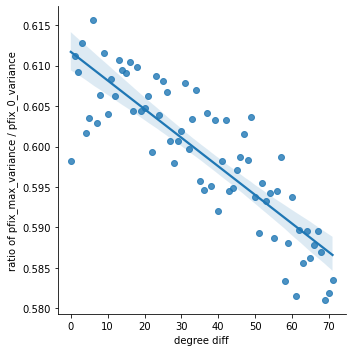

In [13]:
name = "90_10_deg_diff_3reg"
dirname = f"./graphs/{name}/"
result_dirname = f"./graphs/res_{name}"
plot_dir(dirname, result_dirname, "degree diff", line=True)

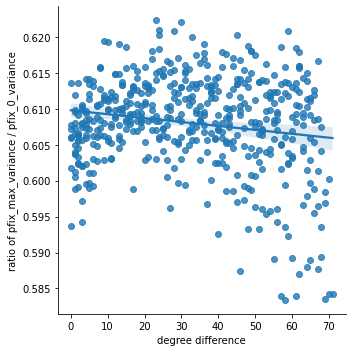

In [14]:
name = "90_10_deg_diff"
dirname = f"./graphs/{name}/"
result_dirname = f"./graphs/res_{name}"
plot_dir(dirname, result_dirname, "degree difference", line=True, color_on=False)
# small component degree 4

In [ ]:
name = "90_10_deg_diff"
dirname = f"./graphs/{name}/"
result_dirname = f"./graphs/res_{name}"
plot_dir(dirname, result_dirname, "degree difference", line=True, color_on=False)
# small component degree 6

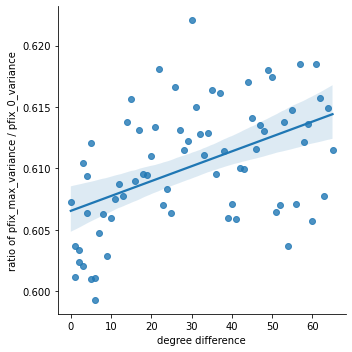

In [ ]:
name = "90_10_deg_diff"
dirname = f"./graphs/{name}/"
result_dirname = f"./graphs/res_{name}"
plot_dir(dirname, result_dirname, "degree difference", line=True, color_on=False)
# small component degree 9

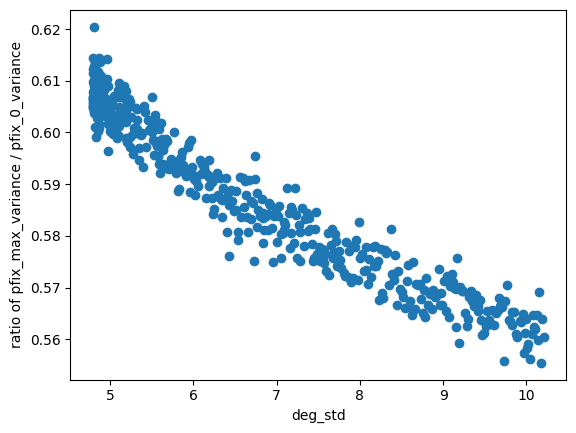

In [ ]:
name = "star_regular_center"
xlabel = "deg_std"
dirname = f"./graphs/{name}/"
result_dirname = f"./graphs/res_{name}"
plot_dir(dirname, result_dirname, xlabel)

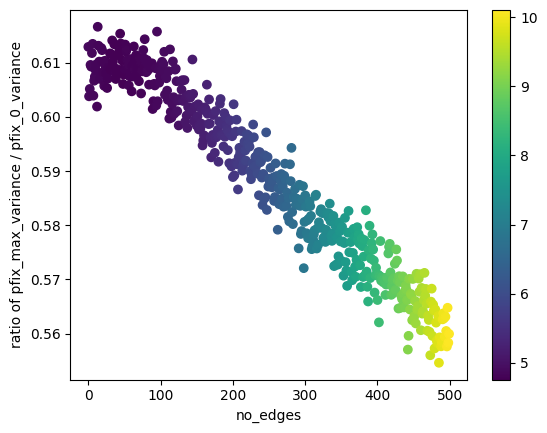

In [ ]:
name = "star_wheel_center"
xlabel = "no_edges"
dirname = f"./graphs/{name}/"
result_dirname = f"./graphs/res_{name}"
plot_dir(dirname, result_dirname, xlabel)

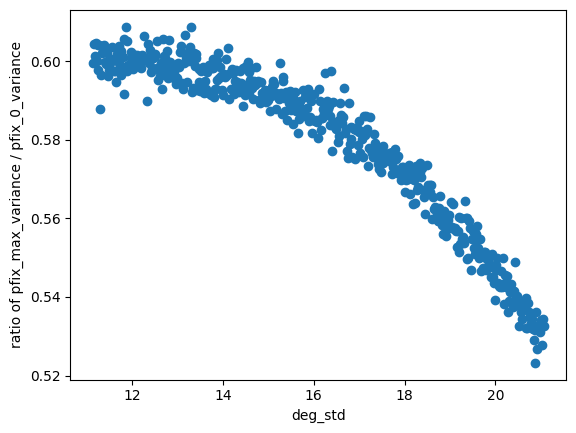

In [ ]:
name = "star_regular_43reg"
xlabel = "deg_std"
dirname = f"./graphs/{name}/"
result_dirname = f"./graphs/res_{name}"
plot_dir(dirname, result_dirname, xlabel)

In [ ]:
def plot_dir_among_all_graphs(namelist):
  x, y = np.load("xs.npy"), np.load("ys.npy")
  fig, ax = plt.subplots()
  ax.scatter(x, y,label="background",s=5)
  for name in namelist:
    dirname = f"./graphs/{name}/"
    result_dirname = f"./graphs/res_{name}"
    
    n = len(os.listdir(f"{result_dirname}1"))
    xs = np.zeros((n,))
    ys = np.zeros((n,))
    for rep in range(1,6):
      result_dir = f"{result_dirname}{rep}"
      for filename in os.listdir(result_dir):
        f = (os.path.join(result_dir,filename))
        id = int(filename.split(".")[0])
        if os.stat(f).st_size == 0:
          print(id, "file is empty")
        data = pd.read_csv(f, sep='\t', header=None)
        xs[id%n] += (data.iloc[0,4])
        ys[id%n] += (data.iloc[1,4])
    ax.scatter(xs/(5), ys / (5), label = name,s=5)
  plt.gca().set(title="", xlabel="pfix 0 variance", ylabel="pfix max variance")
  ax.legend()
  plt.show()

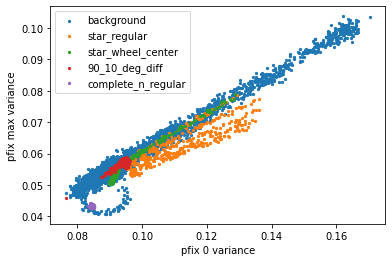

In [ ]:
dirlist = ["star_regular","star_wheel_center","90_10_deg_diff","complete_n_regular"]
plot_dir_among_all_graphs(dirlist)

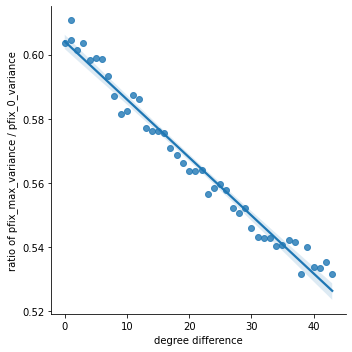

In [ ]:
name = "critical_node5050"
xlabel = "degree difference"
dirname = f"./graphs/{name}/"
result_dirname = f"./graphs/res_{name}"
plot_dir(dirname, result_dirname, xlabel,line=True, color_on=False)

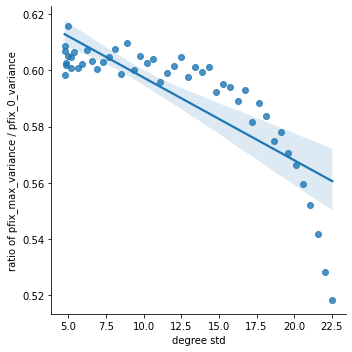

In [ ]:
name = "critical_node_dense5050"
xlabel = "degree difference"
dirname = f"./graphs/{name}/"
result_dirname = f"./graphs/res_{name}"
plot_dir(dirname, result_dirname, xlabel,line=True,color_on=False)

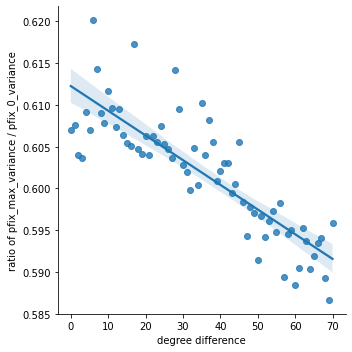

In [ ]:
name = "node_90_10"
xlabel = "degree difference"
dirname = f"./graphs/{name}/"
result_dirname = f"./graphs/res_{name}"
plot_dir(dirname, result_dirname, xlabel,line=True,color_on=False)

In [34]:
def get_param_graph_label(i):
  if i < 0:
    print("error in index")
    return
  if i < 100:
    return "ER p = 0.03"
  # elif i < 200:
  #   return "PA m = 3"
  # elif i < 300:
  #   return "PA m = 5"
  # elif i < 400:
  #   return "PA m = 7"
  elif i < 400:
    return "PA"
  elif i < 450:
    return "Bi"
  elif i < 510:
    return "SW m = 4"
  elif i < 600:
    return "detour"
  elif i < 700:
    return "star"
  else:
    return "rgg"
  # elif i < 750:
  #   return "rgg r= 0.3"
  # else: return "rgg r= 0.5"

## all graph scatter plot

In [45]:
def fx(x, pfix):
  '''return pfix - (1-(1+S_eff)^{-1}) / (1-(1+S_eff)^{-N})
     solving for x = S_eff
  '''
  term = (1 - 1/(1 + x)) / (1 - 1 / ((1 + x) ** 100))
  return pfix-term
  
def plot_effective():
  '''plot the effective fitness S_eff instead of pfix'''
  start = np.array([0.01])
  xs, ys = np.load("pfix0.npy"), np.load("pfixmax.npy")
  n = len(xs)
  # for the general family of graphs
  groups = np.vectorize(get_param_graph_label)(np.arange(0,n))
  
  seff0 = np.zeros((n,))
  seffmax = np.zeros((n,))
  for i in range(n):
    seff0[i] = scipy.optimize.fsolve(fx, x0=start, args=(xs[i]))
    seffmax[i] = scipy.optimize.fsolve(fx, x0=start, args=(ys[i]))
    
  fig, ax = plt.subplots()
  for g in np.unique(groups):
      ix = np.where(groups == g)
      ax.scatter(seff0[ix], seffmax[ix], label = g,s=3)
  m,b = np.polyfit(xs[0:500],ys[0:500],1)
  plt.plot(xs, m*xs + b)
  # plt.plot(xs, 0.632 * xs)
  plt.text(xs[0],ys[0], f"y = {m:.3f}x + {b:.3f}")
  print(m,b)
  ax.legend()
  plt.show()

0.6169145941678491 -0.0007216709370754284


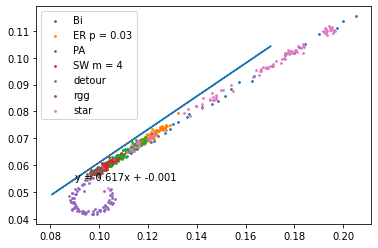

In [46]:
plot_effective()

### hypothesis
- initialize to 1.1
  - most graphs have a negative effective fitness
  - very few has high effective fitness when 0 variance and low when has variance
- initialize to 0.1 or 0.01
  - exact same shape as pfix

In [58]:
p = 0
N = 1000000
for i in range(N):
  u = np.random.uniform()
  if u > 0.5:
    p += np.log2(2)
  else:
    p += np.log2(0.2)
print(p/N)
print(2 ** (p/N))

-0.6613958980940415
0.6322662436179739


## 100 Node graph analysis

In [ ]:
def plot_dir(dirname, result_dirname):
  n = len(os.listdir(f"{result_dirname}1"))
  xs = np.zeros((n,))
  ys = np.zeros((n,))
  degs = np.zeros((n,))
  color = np.zeros((n,)) # amplification factor or whatever it is
  for rep in range(1,6):
    result_dir = f"{result_dirname}{rep}"
    for filename in os.listdir(result_dir):
      f = (os.path.join(result_dir,filename))
      # print(f)
      id = int(filename.split(".")[0])
      if os.stat(f).st_size == 0:
        print(id, "file is empty")
        continue
      data = pd.read_csv(f, sep='\t', header=None)
      graphfile = f"{dirname}{id}.txt"
      xs[id%n] += (data.iloc[0,4])
      ys[id%n] += (data.iloc[1,4])
      
      g = Graph(graphfile)
      degrees = g.degree
      # print(degrees)
      degs[id%n] = abs(degrees[98] - degrees[2]) # np.std(degrees) # abs(degrees[98] - degrees[2]) #
      
      color[id%n] = sum(nx.triangles(g.G).values()) / 3# get_size(id%n) # nx.transitivity(g.G) # g.compute_amplification()
      # g.show()
  ratio = np.divide(np.array(ys),np.array(xs))
  mask = np.isfinite(ratio)
  x_axis = degs
  colors = None
  df = pd.DataFrame({f"{sys.argv[1]}":x_axis,"pfix_max_variance / pfix_0_variance":ratio})
  print(df)
  g = sns.lmplot(x=sys.argv[1], y="pfix_max_variance / pfix_0_variance", data=df)
  # plt.scatter(color,ratio)
  # plt.gca().set(title="", xlabel=sys.argv[1],ylabel="ratio of pfix_max_variance / pfix_0_variance")
  # plt.colorbar()
  g.show()

## Large regular graphs

In [6]:
def plot_largeN(result_dirname, type="line"):
  mod = 19
  xs = np.zeros((mod,))
  ys = np.zeros((mod,))
  count = np.zeros((mod,))
  for rep in range(1,6):
    result_dir = f"{result_dirname}{rep}"
    for filename in os.listdir(result_dir):
      f = (os.path.join(result_dir,filename))
      id = int(filename.split(".")[0])
      if os.stat(f).st_size == 0:
        print(id, rep, "file is empty")
        continue
      data = pd.read_csv(f, sep='\t', header=None)
      xs[id%mod] += (data.iloc[0,4])
      ys[id%mod] += (data.iloc[1,4])
      count[id%mod] += 1
  print(count)
  print(xs/count)
  print(ys/count)
  plt.scatter([(i+1)*50 for i in range(mod)],ys/xs)
  plt.xlabel("population size")
  plt.ylabel("gradient of line")
    

[465. 465. 465. 465. 465. 465. 465. 465. 460. 460. 460. 460. 465. 465.
 465. 465. 465. 465. 465.]
[0.09175862 0.09479802 0.0967109  0.09479768 0.09677839 0.09284985
 0.09094677 0.09091751 0.0909672  0.09090237 0.09087475 0.09086851
 0.09090956 0.09094943 0.09091849 0.09089105 0.09091359 0.09086938
 0.09093019]
[0.05623285 0.05895467 0.06096246 0.05895637 0.06092069 0.05690209
 0.05485187 0.05486899 0.05490193 0.05494226 0.05486433 0.05487472
 0.05481529 0.05488795 0.05493249 0.0548771  0.05486843 0.05487948
 0.05483542]


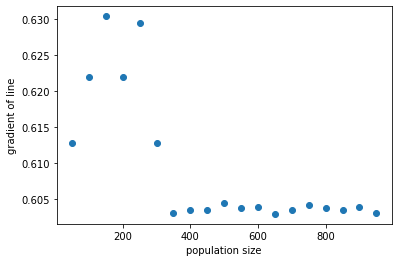

In [31]:
plot_largeN("graphs/res_largeN_regular",type="line")

[495. 495. 495. 490. 490. 493. 479. 408.  24.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.]
[0.16718434 0.1703058  0.17134111 0.17211631 0.17206122 0.1724998
 0.17294008 0.17275956 0.17248333        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan]
[0.10203502 0.10366679 0.10428824 0.10468886 0.10489102 0.10503347
 0.10506472 0.1053451  0.1047            nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan]


/var/folders/k7/1lhkv8ms60z2609pmrg9gfzm0000gn/T/ipykernel_6520/1011996363.py:19: RuntimeWarning: invalid value encountered in true_divide
  print(xs/count)
/var/folders/k7/1lhkv8ms60z2609pmrg9gfzm0000gn/T/ipykernel_6520/1011996363.py:20: RuntimeWarning: invalid value encountered in true_divide
  print(ys/count)
/var/folders/k7/1lhkv8ms60z2609pmrg9gfzm0000gn/T/ipykernel_6520/1011996363.py:21: RuntimeWarning: invalid value encountered in true_divide
  plt.scatter([(i+1)*50 for i in range(mod)],ys/xs)


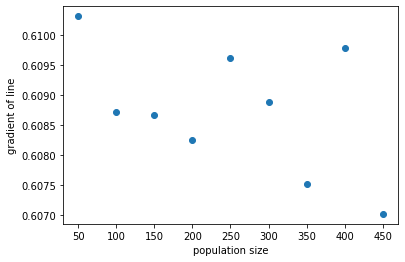

In [32]:
plot_largeN("graphs/res_largeN_star",type="line")

[495. 495. 495. 490. 490. 494. 494. 495. 495. 494. 495. 495. 500. 500.
 500. 495. 494. 495. 495.]
[0.09162611 0.09092694 0.09099131 0.09090853 0.09094562 0.09090248
 0.09090695 0.09089323 0.09090837 0.09092819 0.09086205 0.09091853
 0.09099472 0.09092398 0.09091336 0.09085829 0.0908656  0.09090248
 0.09089899]
[0.05770882 0.0550841  0.0549153  0.05488209 0.05488412 0.05486085
 0.05494291 0.05491699 0.05490357 0.05486618 0.05489172 0.05489761
 0.05490031 0.05487425 0.05483936 0.05491039 0.05486655 0.05486185
 0.05494842]


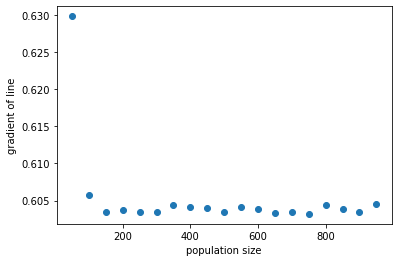

In [33]:
plot_largeN("graphs/res_largeN_wellmixed",type="line")

In [63]:
def plot_largeN_s0(result_dirname, type="line"):
  mod = 19
  xs = np.zeros((mod,))
  ys = np.zeros((mod,))
  count = np.zeros((mod,))
  for rep in range(1,6):
    result_dir = f"{result_dirname}{rep}"
    for filename in os.listdir(result_dir):
      f = (os.path.join(result_dir,filename))
      id = int(filename.split(".")[0])
      if os.stat(f).st_size == 0:
        print(f"file {id} in directory {rep} is empty")
        continue
      data = pd.read_csv(f, sep='\t', header=None)
      x = (data.iloc[0,4])
      y = (data.iloc[1,4])
      
      if id %19 == 1 and (x > 0.012 or x < 0.008):
        continue
      xs[id%mod] += x
      ys[id%mod] += y
      count[id%mod] += 1
  print(count)
  # print(xs/count)
  # print(ys/count)
  pfix = xs/count
  one_over_n = np.array([1 / ((i+1)*50) for i in range(mod)])
  m,b = np.polyfit(one_over_n, pfix, 1)
  print(m,b)
  plt.plot(one_over_n, 1 * one_over_n + 0)
  
  plt.scatter(one_over_n,pfix)
  plt.xlabel("1 / N (population size)")
  plt.ylabel("P-fix no variance")

file 869 in directory 1 is empty
file 1525 in directory 1 is empty
file 1181 in directory 1 is empty
file 1790 in directory 1 is empty
file 1882 in directory 1 is empty
file 305 in directory 2 is empty
file 214 in directory 2 is empty
file 438 in directory 2 is empty
file 1387 in directory 2 is empty
file 1602 in directory 2 is empty
file 1364 in directory 2 is empty
file 121 in directory 2 is empty
file 1475 in directory 2 is empty
file 1521 in directory 3 is empty
file 1408 in directory 3 is empty
file 363 in directory 3 is empty
file 1194 in directory 3 is empty
file 402 in directory 3 is empty
file 577 in directory 3 is empty
file 1834 in directory 3 is empty
file 1488 in directory 3 is empty
file 274 in directory 4 is empty
file 1024 in directory 4 is empty
file 1540 in directory 4 is empty
file 1026 in directory 4 is empty
file 1141 in directory 4 is empty
file 1626 in directory 4 is empty
file 256 in directory 4 is empty
file 1650 in directory 5 is empty
file 1241 in directory 5

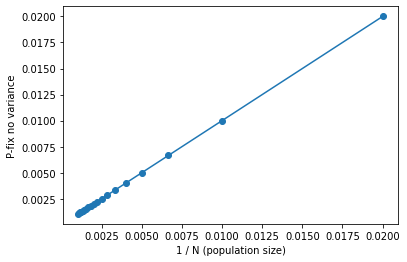

In [64]:
plot_largeN_s0("graphs/res_s0_largeN_wellmixed",type="line")

file 869 in directory 1 is empty
file 1525 in directory 1 is empty
file 1181 in directory 1 is empty
file 1790 in directory 1 is empty
file 1882 in directory 1 is empty
file 305 in directory 2 is empty
file 214 in directory 2 is empty
file 438 in directory 2 is empty
file 1387 in directory 2 is empty
file 1602 in directory 2 is empty
file 1364 in directory 2 is empty
file 121 in directory 2 is empty
file 1475 in directory 2 is empty
file 1521 in directory 3 is empty
file 1408 in directory 3 is empty
file 363 in directory 3 is empty
file 1194 in directory 3 is empty
file 402 in directory 3 is empty
file 577 in directory 3 is empty
file 1834 in directory 3 is empty
file 1488 in directory 3 is empty
file 274 in directory 4 is empty
file 1024 in directory 4 is empty
file 1540 in directory 4 is empty
file 1026 in directory 4 is empty
file 1141 in directory 4 is empty
file 1626 in directory 4 is empty
file 256 in directory 4 is empty
file 1650 in directory 5 is empty
file 1241 in directory 5

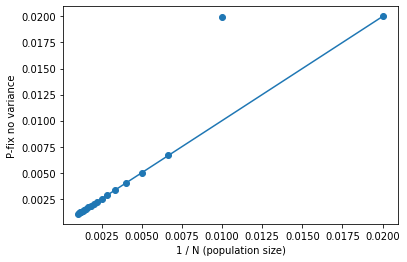

In [56]:
plot_largeN_s0("graphs/res_s0_largeN_wellmixed",type="line")

file 935 in directory 2 is empty
file 1520 in directory 2 is empty
file 896 in directory 3 is empty
file 1866 in directory 3 is empty
file 1253 in directory 3 is empty
file 1054 in directory 3 is empty
file 896 in directory 4 is empty
file 1387 in directory 4 is empty
file 1562 in directory 4 is empty
file 1059 in directory 4 is empty
file 1047 in directory 5 is empty
file 1278 in directory 5 is empty
file 605 in directory 5 is empty
file 553 in directory 5 is empty
file 801 in directory 5 is empty
file 900 in directory 5 is empty
file 1517 in directory 5 is empty
[498. 500. 498. 497. 497. 499. 500. 499. 500. 499. 500. 500. 500. 500.
 499. 500. 498. 500. 499.]
0.9982061594129118 6.6999751212651205e-06


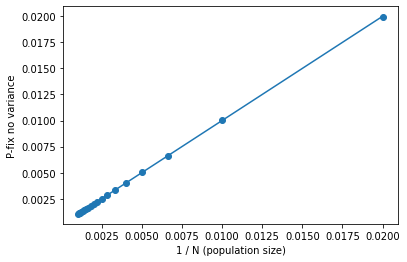

In [31]:
plot_largeN_s0("graphs/res_s0_largeN_regular",type="line")

In [59]:
def plot_largeN_s0_var(result_dirname, type="line"):
  mod = 19
  xs = np.zeros((mod,))
  ys = np.zeros((mod,))
  count = np.zeros((mod,))
  print("Empty files")
  for rep in range(1,6):
    result_dir = f"{result_dirname}{rep}"
    for filename in os.listdir(result_dir):
      f = (os.path.join(result_dir,filename))
      id = int(filename.split(".")[0])
      
      if os.stat(f).st_size == 0:
        print(f"dir {rep} file {id}", end="\t")
        continue

      data = pd.read_csv(f, sep='\t', header=None)
      x = (data.iloc[0,4])
      y = (data.iloc[1,4])
      if x > 1.2 or x < 0.8:
        continue
      xs[id%mod] += x
      ys[id%mod] += y
      count[id%mod] += 1
  print()
  print(count)
  # print(xs/count)
  # print(ys/count)
  pfix = ys/count
  one_over_n = np.array([1 / ((i+1)*50) for i in range(mod)])
  m,b = np.polyfit(one_over_n, pfix, 1)
  print(m, b)
  plt.plot(one_over_n, 1 * one_over_n + b)
  
  plt.scatter(one_over_n,pfix)
  plt.xlabel("1 / N, population size")
  plt.ylabel("Pfix at large variance")

Empty files
dir 1 file 869	dir 1 file 1525	dir 1 file 1181	dir 1 file 1790	dir 1 file 1882	dir 2 file 305	dir 2 file 214	dir 2 file 438	dir 2 file 1387	dir 2 file 1602	dir 2 file 1364	dir 2 file 121	dir 2 file 1475	dir 3 file 1521	dir 3 file 1408	dir 3 file 363	dir 3 file 1194	dir 3 file 402	dir 3 file 577	dir 3 file 1834	dir 3 file 1488	dir 4 file 274	dir 4 file 1024	dir 4 file 1540	dir 4 file 1026	dir 4 file 1141	dir 4 file 1626	dir 4 file 256	dir 5 file 1650	dir 5 file 1241	dir 5 file 1795	dir 5 file 820	dir 5 file 1197	dir 5 file 418	dir 5 file 1211	dir 5 file 1539	dir 5 file 130	dir 5 file 125	
[0. 5. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
nan nan


/var/folders/k7/1lhkv8ms60z2609pmrg9gfzm0000gn/T/ipykernel_4301/2985475904.py:29: RuntimeWarning: invalid value encountered in true_divide
  pfix = ys/count


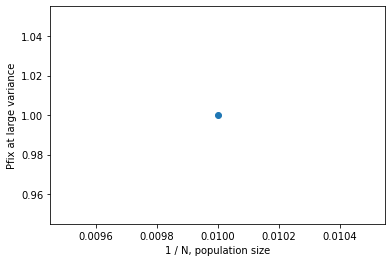

In [60]:
plot_largeN_s0_var("graphs/res_s0_largeN_wellmixed",type="line")

file 869 in directory 1 is empty
file 1525 in directory 1 is empty
file 1181 in directory 1 is empty
file 1790 in directory 1 is empty
file 1882 in directory 1 is empty
file 305 in directory 2 is empty
file 214 in directory 2 is empty
file 438 in directory 2 is empty
file 1387 in directory 2 is empty
file 1602 in directory 2 is empty
file 1364 in directory 2 is empty
file 121 in directory 2 is empty
file 1475 in directory 2 is empty
file 1521 in directory 3 is empty
file 1408 in directory 3 is empty
file 363 in directory 3 is empty
file 1194 in directory 3 is empty
file 402 in directory 3 is empty
file 577 in directory 3 is empty
file 1834 in directory 3 is empty
file 1488 in directory 3 is empty
file 274 in directory 4 is empty
file 1024 in directory 4 is empty
file 1540 in directory 4 is empty
file 1026 in directory 4 is empty
file 1141 in directory 4 is empty
file 1626 in directory 4 is empty
file 256 in directory 4 is empty
file 1650 in directory 5 is empty
file 1241 in directory 5

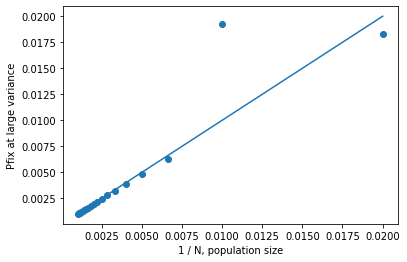

In [34]:
plot_largeN_s0_var("graphs/res_s0_largeN_wellmixed",type="line")

Empty files
dir 2 file 935	dir 2 file 1520	dir 3 file 896	dir 3 file 1866	dir 3 file 1253	dir 3 file 1054	dir 4 file 896	dir 4 file 1387	dir 4 file 1562	dir 4 file 1059	dir 5 file 1047	dir 5 file 1278	dir 5 file 605	dir 5 file 553	dir 5 file 801	dir 5 file 900	dir 5 file 1517	
[498. 500. 498. 497. 497. 499. 500. 499. 500. 499. 500. 500. 500. 500.
 499. 500. 498. 500. 499.]
0.7176303695452776 8.128191071148503e-06


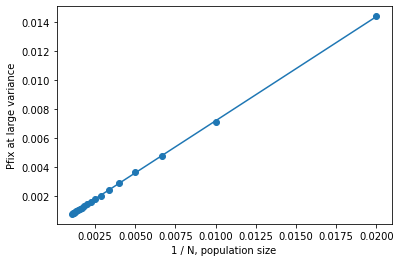

In [49]:
plot_largeN_s0_var("graphs/res_s0_largeN_regular",type="line")

# Small graph of size 10

In [75]:
def retrieve_result(name, alert=False):
  result_dirname = f"./graphs/res_{name}"
  n = len(os.listdir(f"{result_dirname}1"))
  xs = np.zeros((n,))
  ys = np.zeros((n,))
  N = 1
  for rep in range(1,N+1):
    result_dir = f"{result_dirname}{rep}"
    for filename in os.listdir(result_dir):
      f = (os.path.join(result_dir,filename))
      id = int(filename.split(".")[0])
      if os.stat(f).st_size == 0:
        print(id, "file is empty")
        xs[id%n] = None
        ys[id%n] = None
        continue
      data = pd.read_csv(f, sep='\t', header=None)
      pfix_max,pfix0 = (data.iloc[1,4]), (data.iloc[0,4])
      xs[id%n] += pfix0
      ys[id%n] += pfix_max
      if alert:
        print(id, pfix_max/pfix0, pfix0, pfix_max)
  return xs, ys

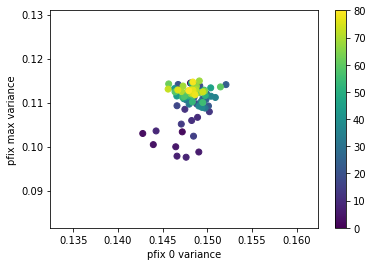

In [13]:
name = "pop_size_10"
x,y = retrieve_result(name)
plt.scatter(x, y, c=[i for i in range(n)])
plt.colorbar()
plt.gca().set(title="", xlabel="pfix 0 variance", ylabel="pfix max variance")
# ax.legend()
plt.show()

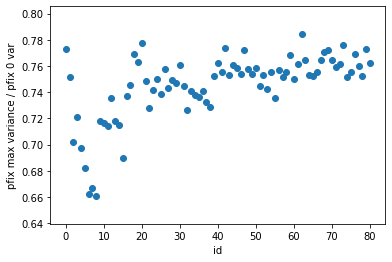

In [14]:
name = "pop_size_10"
x,y = retrieve_result(name)
plt.scatter([i for i in range(n)], y/x)
# plt.colorbar()
plt.gca().set(title="", xlabel="id", ylabel="pfix max variance / pfix 0 var")
# ax.legend()
plt.show()

(array([], dtype=int64),)
14 0.7545534565644255 0.14769000000000002 0.11144000000000001
13 0.7477486518673143 0.14946600000000002 0.11176300000000002
12 0.7356850715746419 0.144744 0.10648599999999998
10 0.7115786394785225 0.143592 0.102177
11 0.7298161309427664 0.148584 0.10843900000000001
9 0.7192200856134513 0.149042 0.10719400000000001
8 0.6984759217768927 0.144612 0.101008
5 0.7075402659563947 0.151679 0.10731900000000001
4 0.6945700903982736 0.149671 0.103957
6 0.6827880122859704 0.14618299999999998 0.099812
7 0.6988982042333559 0.149574 0.10453699999999999
3 0.6736980436785346 0.147624 0.099454
2 0.702389915316912 0.150089 0.105421
0 0.6631120315210521 0.148726 0.098622
1 0.6858823924957131 0.148715 0.102001
0.6194860889614532 0.01684403955136855


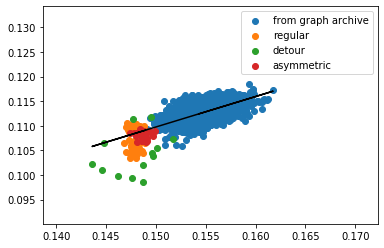

In [77]:
# name = "group_1_graphs"
# x1,y1 = retrieve_result(name)
name = "group_100_graphs"
x2,y2 = retrieve_result(name)
print(np.where(x2 == 0))
name = "pop_size_10_a"
dx, dy = retrieve_result(name, alert=True)
name = "pop_size_10_reg"
rx,ry = retrieve_result(name)
xs, ys = np.hstack((x1,x2)), np.hstack((y1,y2))
plt.scatter(x2,y2, label="from graph archive")
plt.scatter(rx,ry,label="regular")
plt.scatter(dx,dy,label="detour")
ax, ay = retrieve_result("pop_size_10_asym")
plt.scatter(ax,ay,label="asymmetric")
x, y = np.hstack((x2,dx,rx,ax)), np.hstack((y2,dy,ry,ay))
m,b = np.polyfit(x,y,1)
print(m,b)
plt.plot(x, m * x + b, 'k')
plt.legend()

In [95]:
def retrieve_graph(f, name,norm=False):
  graph_dirname = f"./graphs/{name}/"
  n = len(os.listdir(f"{graph_dirname}"))
  res = np.zeros((n,))
  for i in range(n):
    g_text = f"{graph_dirname}/{i+1}.txt"
    g = nx.read_edgelist(g_text,nodetype=int)
    res[i] = f(g,normalized=norm)
  return res

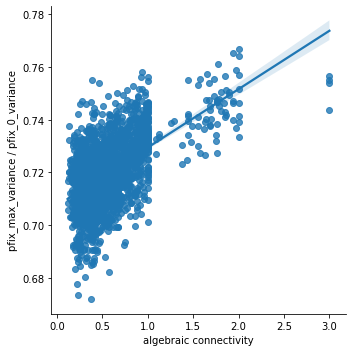

In [93]:
name = "group_1_graphs"
x1,y1 = retrieve_result(name)
c1 = retrieve_graph(nx.algebraic_connectivity, name)
df = pd.DataFrame({f"algebraic connectivity":c1,"pfix_max_variance / pfix_0_variance":y1 / x1})
# print(df)
# plt.scatter(x1,y1, hue=c1)
g = sns.lmplot(x="algebraic connectivity", y="pfix_max_variance / pfix_0_variance", data=df)
# name = "group_100_graphs"

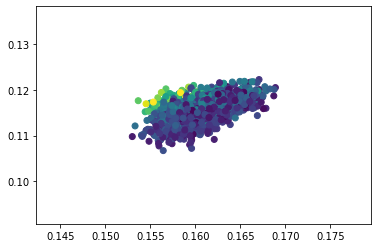

In [98]:
c1_norm = retrieve_graph(nx.algebraic_connectivity, name,norm=True)
df = pd.DataFrame({f"algebraic connectivity":c1_norm,"pfix_max_variance / pfix_0_variance":y1 / x1})
# print(df)
plt.scatter(x1,y1, c=c1_norm)
# g = sns.lmplot(x="algebraic connectivity", y="pfix_max_variance / pfix_0_variance", data=df)
# name = "group_100_graphs"

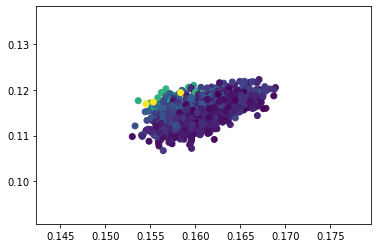

In [88]:
name = "group_1_graphs"
x1,y1 = retrieve_result(name)
c1 = retrieve_graph(nx.algebraic_connectivity, name)
df = pd.DataFrame({f"algebraic connectivity":c1,"pfix_max_variance / pfix_0_variance":y1 / x1})
# print(d
plt.scatter(x1,y1, c=c1)
# g = sns.lmplot(x="algebraic connectivity", y="pfix_max_variance / pfix_0_variance", data=df)
# name = "group_100_graphs"
# x2,y2 = retrieve_result(name)
# c2 = retrieve_graph(nx.algebraic_connectivity, name)

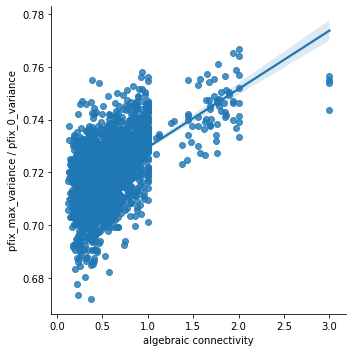

In [91]:
name = "group_100_graphs"
x2,y2 = retrieve_result(name)
c2 = retrieve_graph(nx.algebraic_connectivity, name)
df = pd.DataFrame({f"algebraic connectivity":c1,"pfix_max_variance / pfix_0_variance":y1 / x1})
# print(df)
g = sns.lmplot(x="algebraic connectivity", y="pfix_max_variance / pfix_0_variance", data=df)
# name = "group_100_graphs"
# x2,y2 = retrieve_result(name)
# c2 = retrieve_graph(nx.algebraic_connectivity, name)

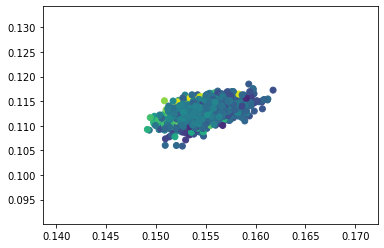

In [92]:
plt.scatter(x2,y2, c=c2)

# Analysis on graphs of 100 nodes

In [60]:
def check_graph_properties(graph_dirname, xfunc, yfunc):
  '''
  @params:
  xfunc, yfunc are strings that corresponds to the graph properties of interests
  '''
  n = len(os.listdir(f"{graph_dirname}"))
  xs = np.zeros((n,))
  ys = np.zeros((n,))
  count = 0
  for filename in os.listdir(graph_dirname):
    f = (os.path.join(graph_dirname,filename))
    # print(filename)
    id = (filename.split(".")[0])
    if not id.isnumeric():
      continue
    else: id = int(id)
    if os.stat(f).st_size == 0:
      print(id, rep, "file is empty")
      continue
    graphfile = f"{graph_dirname}/{id}.txt"
    g = Graph(graphfile)
    # print(id, end=",")
    count += 1
    if count %100 == 0: print(".",end="",flush=True)
    if xfunc.startswith("alg") or yfunc.startswith("alg") and 440<= id < 450:
      x, y = None, None
    else:
      x, y = g.get_property(xfunc),g.get_property(yfunc)
    xs[id] = x
    ys[id] = y
    
  # print(xs, ys)
  # plt.scatter(xs,ys,c=[get_param_graph_label(i) for i in range(n)])
  # plt.xlabel(xfunc)
  # plt.ylabel(yfunc)
  # plt.colorbar()
  # plt.show()
  # plt.clf()
  df = pd.DataFrame({xfunc:xs,yfunc:ys,"id":[i for i in range(n)]})
  df["graph type"] = df["id"].apply(get_param_graph_label)
  sns.lmplot(x=xfunc,y=yfunc,data=df, hue="graph type")
  plt.xlabel(xfunc)
  plt.ylabel(yfunc)
    

In [78]:
def check_property_against_result(func):
  ''' assume for param graphs here, since results are already in npy file
  '''
  graph_dirname = "param_graphs"
  x, y = np.load("pfix0.npy"), np.load("pfixmax.npy")
  ys = y / x
  n = len(os.listdir(f"{graph_dirname}")) -1
  xs = np.zeros((n,))
  count = 0
  for filename in os.listdir("param_graphs"):
    f = (os.path.join(graph_dirname,filename))
    # print(filename)
    id = (filename.split(".")[0])
    if not id.isnumeric():
      continue
    else: id = int(id)
    if os.stat(f).st_size == 0:
      print(id, rep, "file is empty")
      continue
    graphfile = f"{graph_dirname}/{id}.txt"
    g = Graph(graphfile)
    # print(id, end=",")
    count += 1
    if count %100 == 0: print(".",end="",flush=True)
    if func.startswith("alg") and 440<= id < 450:
      x = None
    else:
      x = g.get_property(func)
    xs[id] = x
    # print(len(xs),len(ys))
  df = pd.DataFrame({func:xs,"pfix_max/pfix_0":ys,"id":[i for i in range(n)]})
  df["graph type"] = df["id"].apply(get_param_graph_label)
  sns.lmplot(x=func,y="pfix_max/pfix_0",data=df, hue="graph type")
  plt.xlabel(func)
  plt.ylabel("pfix_max/pfix_0")
  
  

## Correlation between graph property and result

........

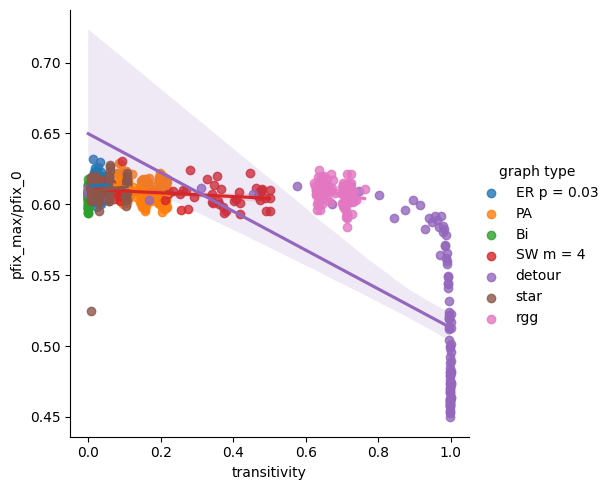

In [79]:
check_property_against_result("transitivity")

........

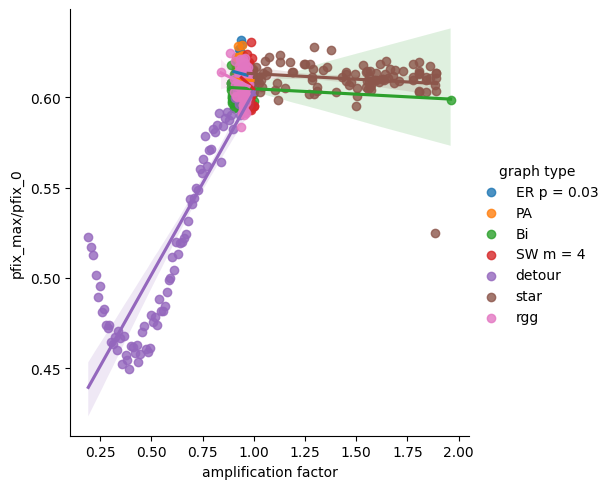

In [80]:
check_property_against_result("amplification factor")

.

/usr/local/lib/python3.10/site-packages/networkx/algorithms/assortativity/correlation.py:298: RuntimeWarning: invalid value encountered in scalar divide
  return (xy * (M - ab)).sum() / np.sqrt(vara * varb)


.......

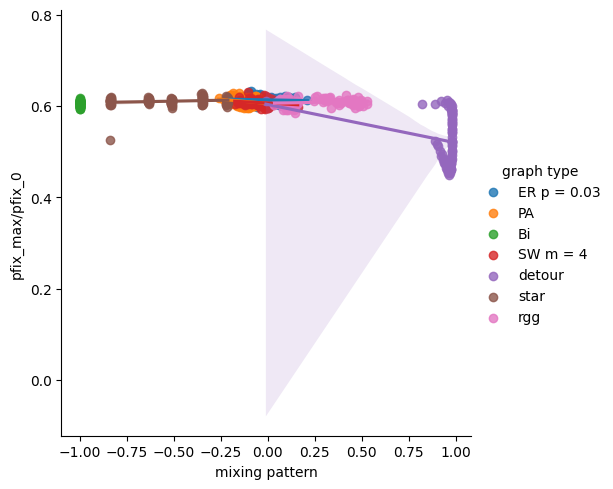

In [81]:
check_property_against_result("mixing pattern")

........

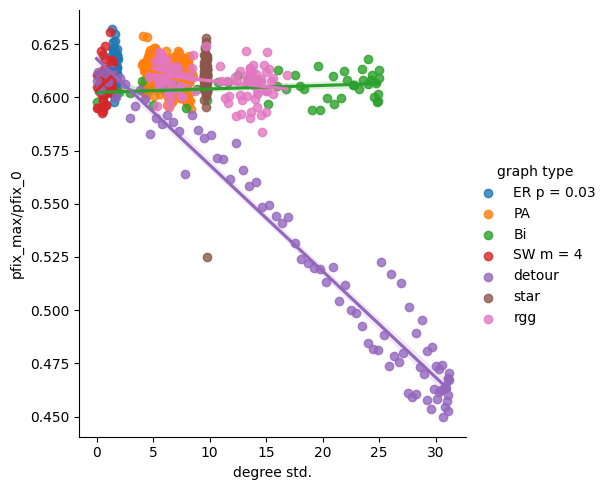

In [82]:
check_property_against_result("degree std.")

<class 'networkx.utils.decorators.argmap'> compilation 22:4: FutureWarning: laplacian_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.


........

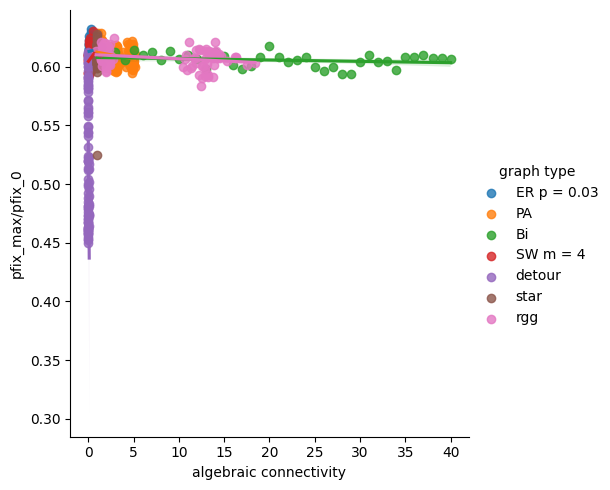

In [83]:
check_property_against_result("algebraic connectivity")

........

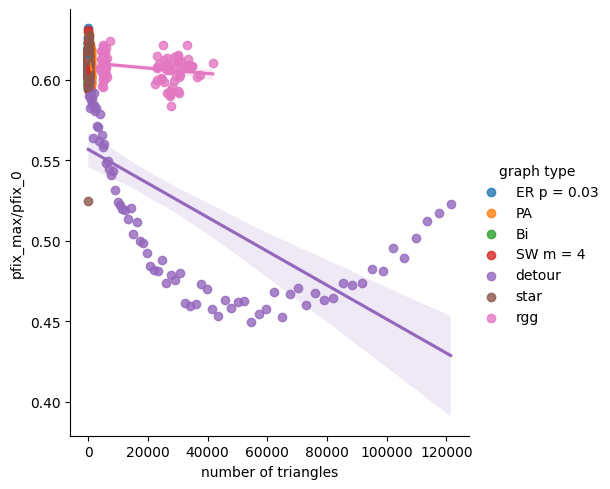

In [84]:
check_property_against_result("number of triangles")

........

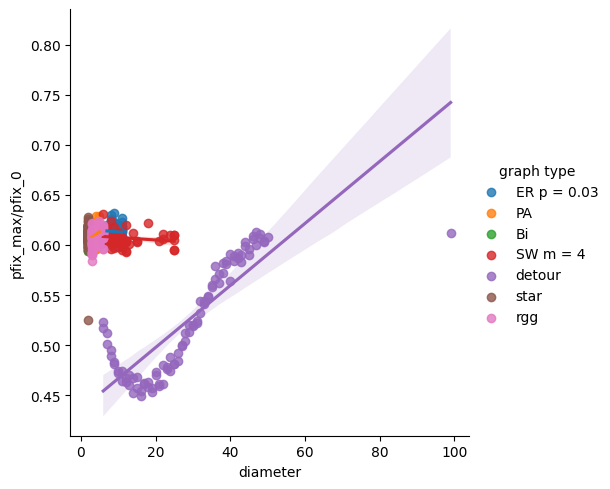

In [85]:
check_property_against_result("diameter")

........

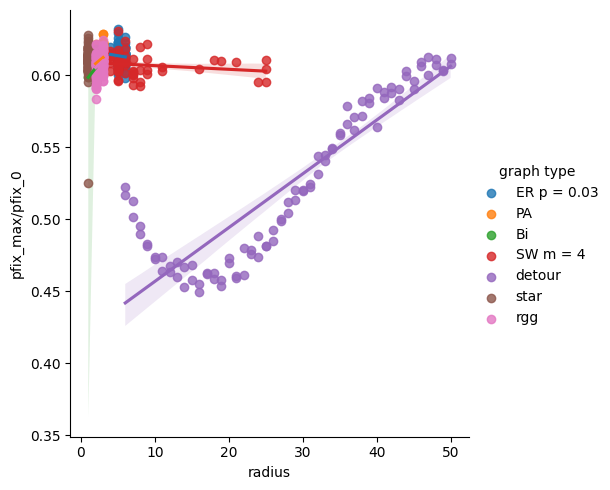

In [86]:
check_property_against_result("radius")

## checking graph properties

/usr/local/lib/python3.10/site-packages/networkx/algorithms/assortativity/correlation.py:298: RuntimeWarning: invalid value encountered in scalar divide
  return (xy * (M - ab)).sum() / np.sqrt(vara * varb)


........

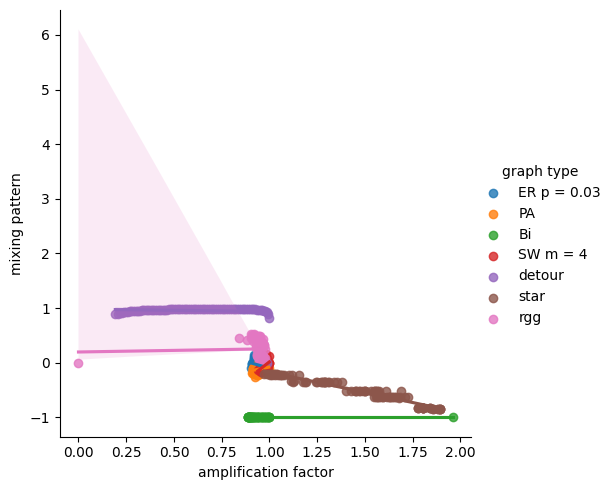

In [37]:
check_graph_properties("param_graphs", "amplification factor", "mixing pattern")

........

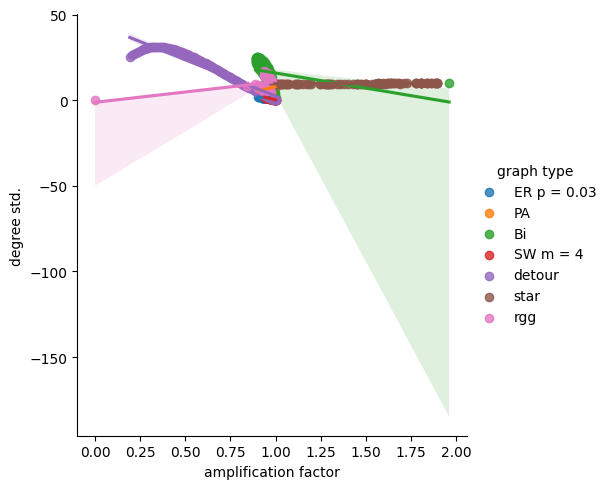

In [38]:
check_graph_properties("param_graphs", "amplification factor", "degree std.")

........

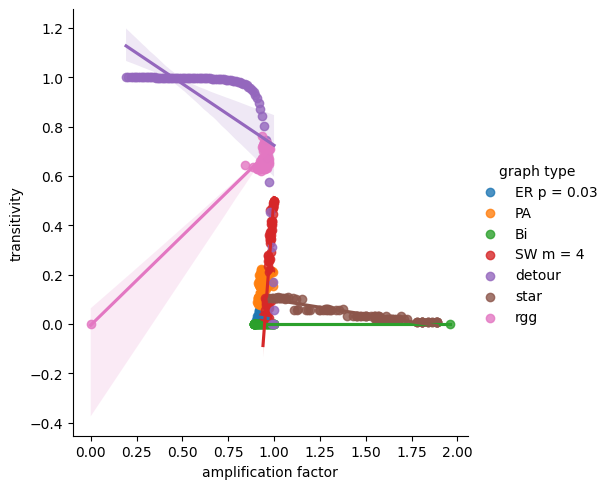

In [39]:
check_graph_properties("param_graphs", "amplification factor", "transitivity")

<class 'networkx.utils.decorators.argmap'> compilation 22:4: FutureWarning: laplacian_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.


........

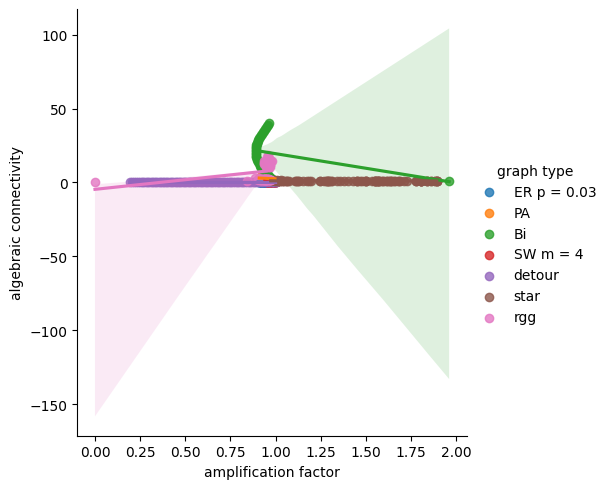

In [40]:
check_graph_properties("param_graphs", "amplification factor", "algebraic connectivity")

.

/usr/local/lib/python3.10/site-packages/networkx/algorithms/assortativity/correlation.py:298: RuntimeWarning: invalid value encountered in scalar divide
  return (xy * (M - ab)).sum() / np.sqrt(vara * varb)


.......

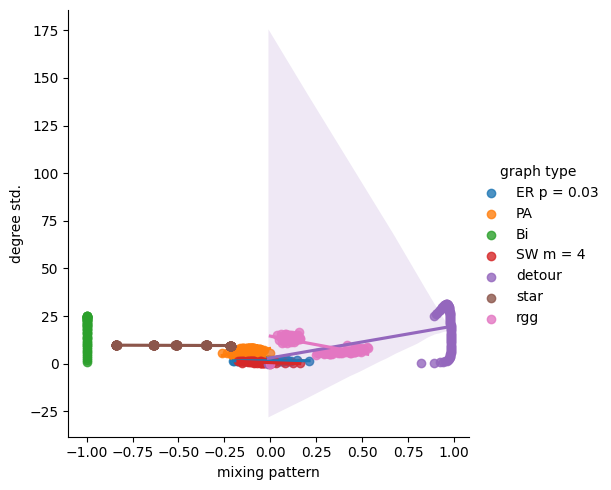

In [41]:
check_graph_properties("param_graphs", "mixing pattern", "degree std.")

/usr/local/lib/python3.10/site-packages/networkx/algorithms/assortativity/correlation.py:298: RuntimeWarning: invalid value encountered in scalar divide
  return (xy * (M - ab)).sum() / np.sqrt(vara * varb)


........

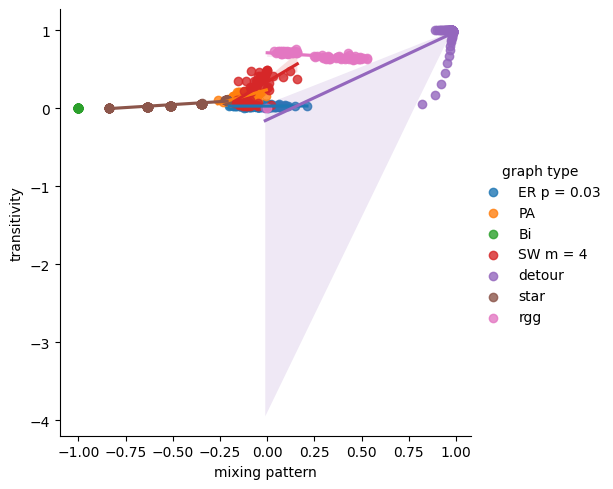

In [42]:
check_graph_properties("param_graphs", "mixing pattern", "transitivity")

<class 'networkx.utils.decorators.argmap'> compilation 22:4: FutureWarning: laplacian_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
/usr/local/lib/python3.10/site-packages/networkx/algorithms/assortativity/correlation.py:298: RuntimeWarning: invalid value encountered in scalar divide
  return (xy * (M - ab)).sum() / np.sqrt(vara * varb)


........

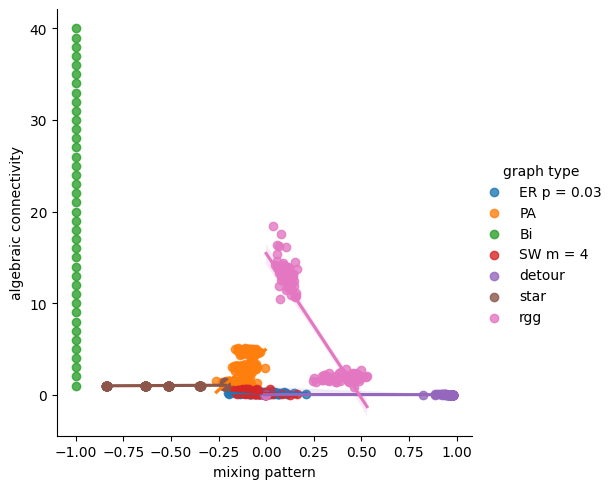

In [43]:
check_graph_properties("param_graphs", "mixing pattern", "algebraic connectivity")

........

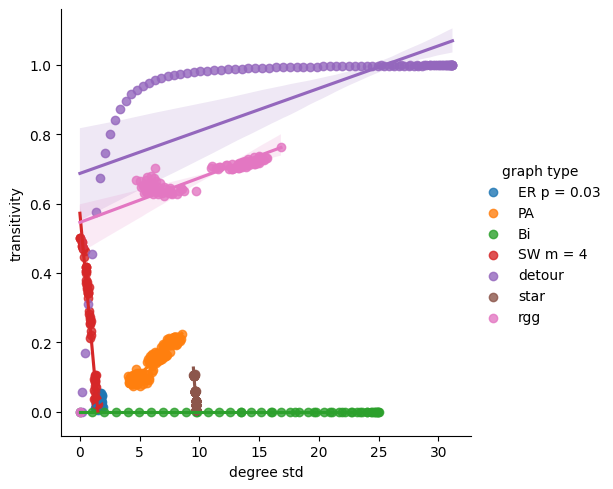

In [44]:
check_graph_properties("param_graphs", "degree std", "transitivity")

<class 'networkx.utils.decorators.argmap'> compilation 22:4: FutureWarning: laplacian_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.


........

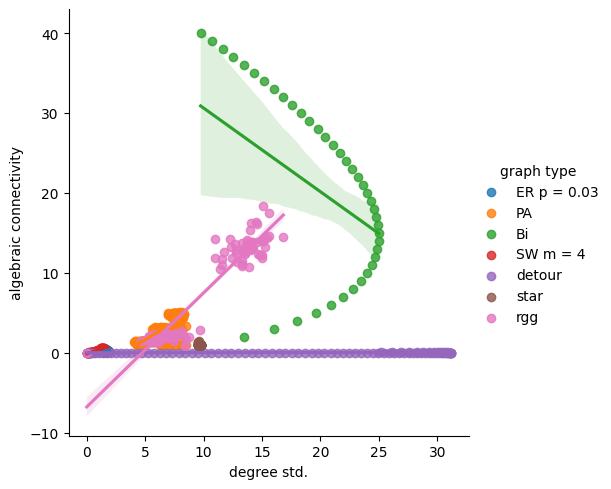

In [45]:
check_graph_properties("param_graphs", "degree std.", "algebraic connectivity")

<class 'networkx.utils.decorators.argmap'> compilation 22:4: FutureWarning: laplacian_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.


........

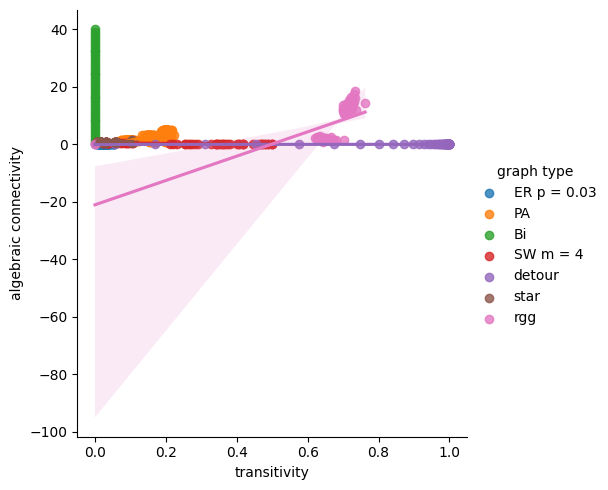

In [46]:
check_graph_properties("param_graphs", "transitivity", "algebraic connectivity")

<class 'networkx.utils.decorators.argmap'> compilation 22:4: FutureWarning: laplacian_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.


........

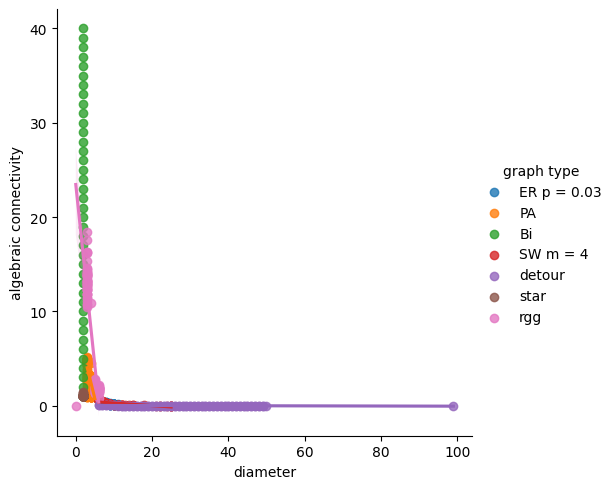

In [47]:
check_graph_properties("param_graphs", "diameter", "algebraic connectivity")

........

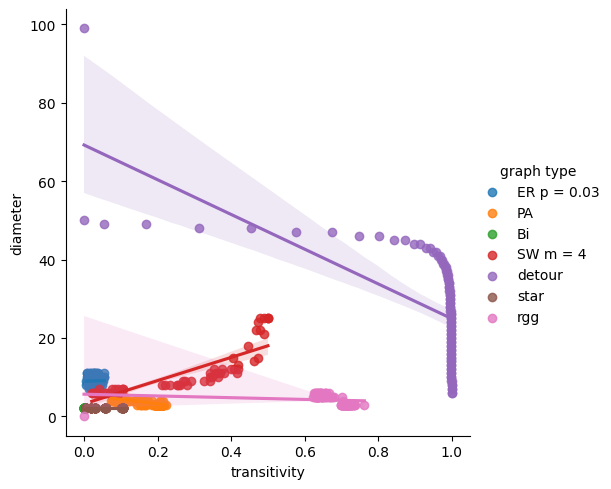

In [48]:
check_graph_properties("param_graphs", "transitivity", "diameter")

........

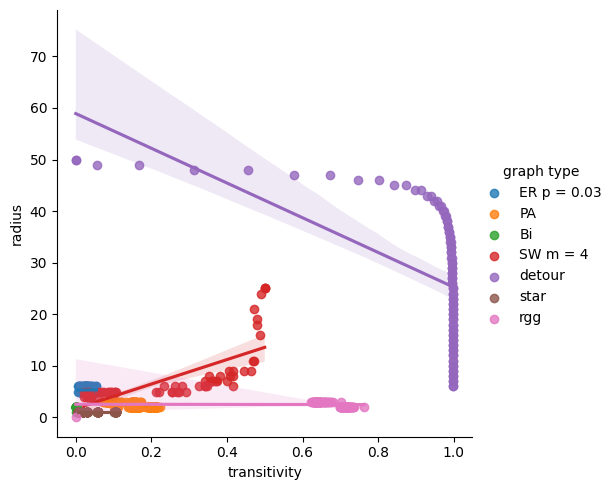

In [51]:
check_graph_properties("param_graphs", "transitivity", "radius")

........

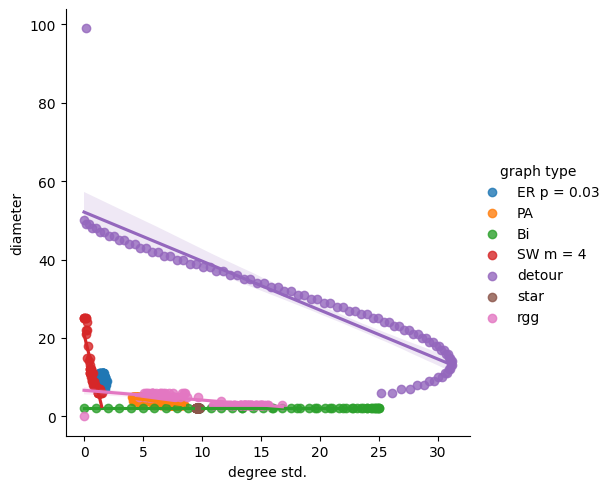

In [49]:
check_graph_properties("param_graphs", "degree std.", "diameter")

........

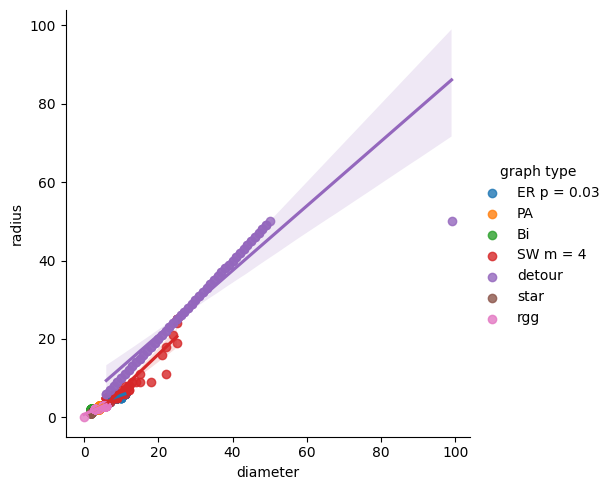

In [50]:
check_graph_properties("param_graphs", "diameter", "radius")

# Analysis of other graphs of 100 node

In [37]:
import glob
def plot_ratio(result_dirname, xaxis="",yaxis=""):
  n = 800
  xs = np.zeros((n,))
  ys = np.zeros((n,))
  count = np.zeros((n,))
  for rep in range(1,6):
    result_dir = f"{result_dirname}{rep}"
    # print(result_dir)
    for filename in glob.glob(result_dir+'/*out.txt'):
      name = filename.split("/")[-1]
      id = int(name.split("out")[0])
      if os.stat(filename).st_size == 0:
        print(id, "file is empty")
        continue
      data = pd.read_csv(filename, sep='\t', header=None)
      xs[id%n] += (data.iloc[0,5])
      ys[id%n] += (data.iloc[1,5])
      count[id%n] += 1
  
  xs = xs/count
  ys = ys/count
  mask= np.isfinite(xs/ys)
  
  df = pd.DataFrame({xaxis:xs,yaxis:ys,"id":[i for i in range(n)]})
  print(df)
  df["graph type"] = df["id"].apply(get_param_graph_label)
  g = sns.lmplot(x=xaxis, y=yaxis, data=df, hue="graph type")
  # plt.scatter(color,ratio)
  # plt.gca().set(title="", xlabel=sys.argv[1],ylabel="ratio of pfix_max_variance / pfix_0_variance")
  # plt.colorbar()
  # g.show()

     ratio no variance  ratio with variance   id
0             0.500254             0.687235    0
1             0.499984             0.674902    1
2             0.500206             0.658736    2
3             0.500354             0.674534    3
4             0.499888             0.667853    4
..                 ...                  ...  ...
795           0.500350             0.532774  795
796           0.499396             0.531900  796
797           0.500008             0.534560  797
798           0.499687             0.534809  798
799           0.500283             0.531737  799

[800 rows x 3 columns]


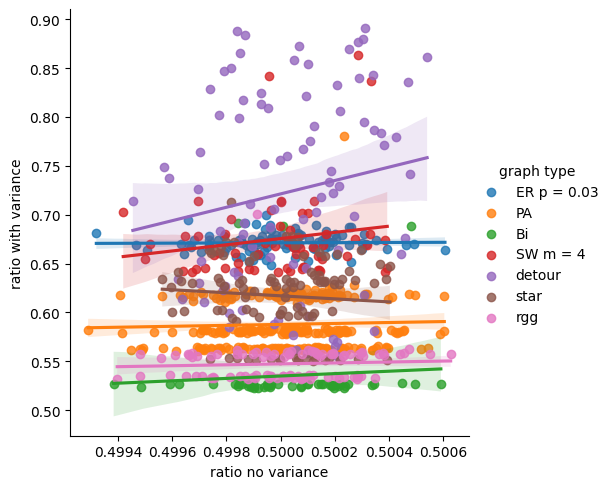

In [38]:
result_dirname = "graphs/result_param_graphs"
plot_ratio(result_dirname, "ratio no variance", "ratio with variance")